# Diploma. Fedorov Dmitrii
## Apples Diseases Detection



### Python and libaries versions

In [23]:
import sys
import os
import cv2
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

# threshold
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive, fixed

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout


print("Python version:")
print(sys.version)

Python version:
3.9.5 (default, Feb 15 2023, 19:12:36) 
[GCC 11.3.0]


# Plan

1. Dataset uploading
2. Image preprocessing
3. Data augmentation
4. Model teaching and testing
5. Model testing

## Dataset uploading

Dataset link - https://www.kaggle.com/datasets/kaivalyashah/apple-disease-detection

In [2]:
# functions
def load_images(data_path):
    images, labels = [], []
    for fruit_type in os.listdir(data_path):
        fruit_type_data_path = os.path.join(data_path, fruit_type)
        
        for image in os.listdir(fruit_type_data_path):
            images.append(cv2.imread(os.path.join(fruit_type_data_path, image)))
            labels.append(fruit_type)

    return shuffle(images, labels, random_state=25)

def show_images(images_array):
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))

    array_rgb = [cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in images_array]

    for i, ax in enumerate(axes.flat):
        ax.imshow(array_rgb[i])
        ax.axis('off')

    plt.show()

In [3]:
train_path = "apple_disease_classification/Train"
test_path = "apple_disease_classification/Test"

images_train, labels_train = load_images(train_path)

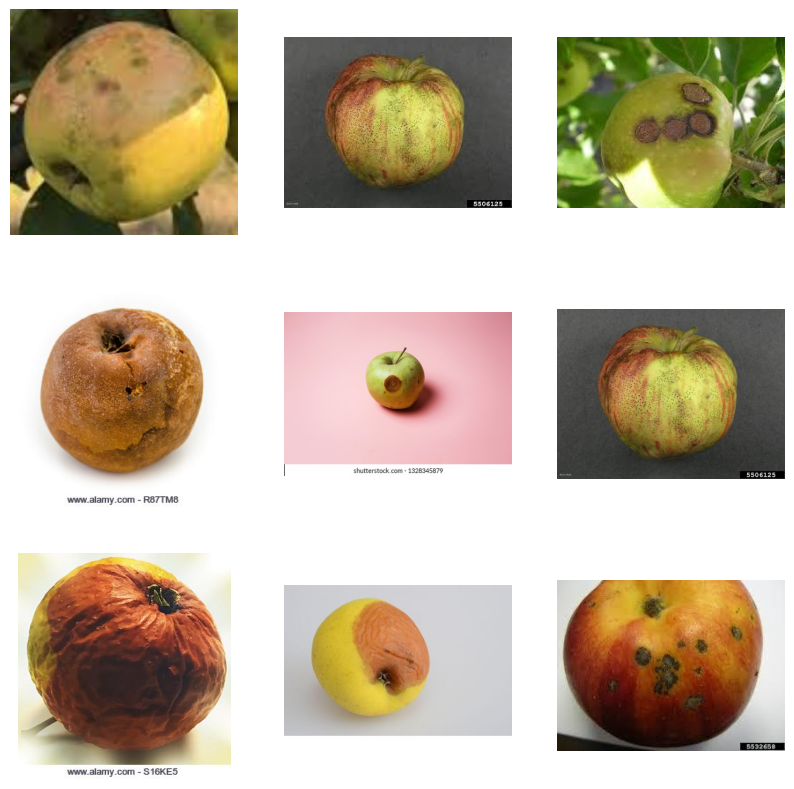

In [4]:
show_images(images_train)

In [5]:
images_train[0]

array([[[ 86, 121, 117],
        [ 81, 116, 112],
        [ 74, 109, 105],
        ...,
        [ 57, 145, 145],
        [ 56, 146, 146],
        [ 57, 147, 147]],

       [[ 85, 120, 116],
        [ 79, 114, 110],
        [ 71, 106, 102],
        ...,
        [ 57, 145, 145],
        [ 57, 145, 145],
        [ 56, 146, 146]],

       [[ 81, 118, 114],
        [ 75, 112, 108],
        [ 66, 103,  99],
        ...,
        [ 54, 142, 142],
        [ 55, 143, 143],
        [ 56, 144, 144]],

       ...,

       [[ 65,  89, 107],
        [ 61,  85, 103],
        [ 59,  85, 102],
        ...,
        [ 88, 145, 171],
        [ 89, 146, 172],
        [ 89, 146, 172]],

       [[ 65,  89, 107],
        [ 61,  85, 103],
        [ 59,  85, 102],
        ...,
        [ 88, 145, 171],
        [ 89, 146, 172],
        [ 89, 146, 172]],

       [[ 64,  90, 107],
        [ 60,  86, 103],
        [ 59,  85, 102],
        ...,
        [ 85, 143, 172],
        [ 87, 146, 172],
        [ 88, 147, 173]]

## Image preprocessing

### Pre-processing

it can be beneficial to preprocess images before removing the background. Preprocessing can help enhance image quality, reduce noise, and improve the overall performance of the background removal process. Here are a few common preprocessing techniques you can consider:

Resize images: Resizing images to a standard size can help with the consistency of the background removal process, especially when working with a large dataset of images with different dimensions.

Color space conversion: Converting the image to different color spaces, such as HSV or LAB, can make it easier to identify and separate the objects of interest from the background.

Histogram equalization: Applying histogram equalization can help improve the contrast of the image, making it easier to distinguish between the foreground and background.

Noise reduction: Images may contain noise, such as salt-and-pepper noise or Gaussian noise, which can affect the quality of the background removal process. You can use filters like the median filter or Gaussian blur to reduce noise in the images.

Image enhancement: Adjusting brightness, contrast, or applying filters like unsharp masking can enhance the image's overall quality, making it easier to detect the objects of interest.

When implementing these preprocessing techniques, keep in mind that the choice and order of the methods will depend on your specific dataset and requirements. Some experimentation might be necessary to achieve the best results for your particular use case.

In [6]:
# Functions

def preprocess_image(image_array):
    # 1. Resize images
    resized_image = cv2.resize(image_array, (300, 300))

    # 2. Color space conversion (HSV)
    hsv_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2HSV)

    # 3. Histogram equalization
    # Equalize the histogram of the V channel
    hsv_channels = list(cv2.split(hsv_image))  # Convert the tuple to a list
    hsv_channels[2] = cv2.equalizeHist(hsv_channels[2])
    equalized_hsv_image = cv2.merge(tuple(hsv_channels))  # Convert the list back to a tuple

    # Convert back to BGR color space
    equalized_image = cv2.cvtColor(equalized_hsv_image, cv2.COLOR_HSV2BGR)

    # 4. Noise reduction (Gaussian blur)
    blurred_image = cv2.GaussianBlur(equalized_image, (5, 5), 0)

    # 5. Image enhancement (Unsharp masking)
    blurred_image_float = blurred_image.astype(np.float32)
    sharpened_image_float = cv2.addWeighted(blurred_image_float, 1.5, cv2.GaussianBlur(blurred_image_float, (5, 5), 0), -0.5, 0)
    sharpened_image = sharpened_image_float.astype(np.uint8)

    return sharpened_image

In [7]:
preprocessed_train = np.array([preprocess_image(img) for img in images_train])

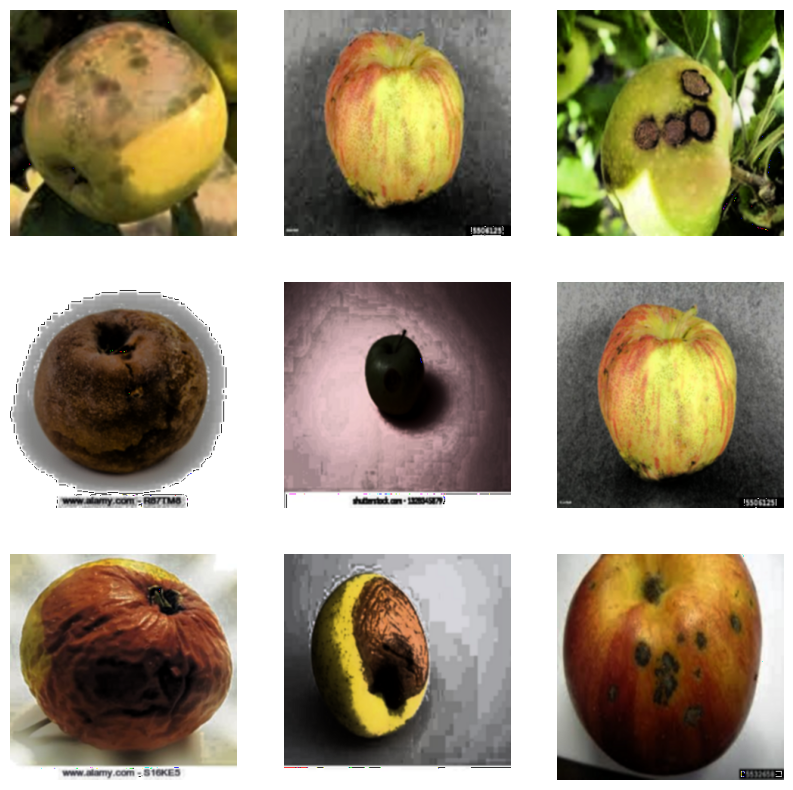

In [8]:
show_images(preprocessed_train)

### Remove background

In [9]:
# Functions

def remove_background(image_array, lower_color_bound, upper_color_bound):
    # Convert the image to HSV color space
    hsv_image = cv2.cvtColor(image_array, cv2.COLOR_BGR2HSV)

    # Create a mask based on the color bounds
    mask = cv2.inRange(hsv_image, lower_color_bound, upper_color_bound)

    # Invert the mask
    mask_inverse = cv2.bitwise_not(mask)

    # Apply the mask to the original image to remove the background
    result = cv2.bitwise_and(image_array, image_array, mask=mask_inverse)

    return result

#### Remove gray color - not working

In [10]:
def remove_grey(image_array, lower_color_bounds, upper_color_bounds):
    hsv_image = cv2.cvtColor(image_array, cv2.COLOR_BGR2HSV)
    
    masks = []
    for lower_color_bound, upper_color_bound in zip(lower_color_bounds, upper_color_bounds):
        # Create a mask based on the color bounds
        mask = cv2.inRange(hsv_image, lower_color_bound, upper_color_bound)
        masks.append(mask)
    
    # Combine the masks for red and green apples
    combined_mask = cv2.bitwise_or(masks[0], masks[1])
    
    # Invert the mask
    mask_inverse = cv2.bitwise_not(combined_mask)
    
    # Apply the inverted mask to the original image
    result = cv2.bitwise_and(image_array, image_array, mask=mask_inverse)

    return result

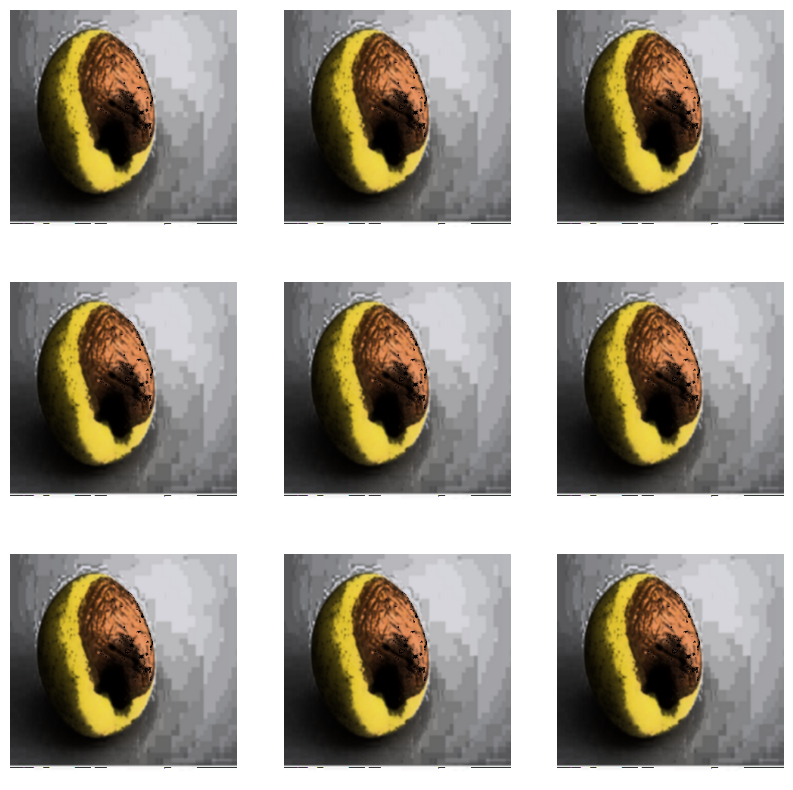

In [11]:
lower_thresholds = [np.array([0, 50, 50]), np.array([50, 50, 50])]  # [Red lower bound, Green lower bound]
upper_thresholds = [np.array([10, 255, 255]), np.array([70, 255, 255])]  # [Red upper bound, Green upper bound]

remove_grey = np.array([remove_grey(preprocessed_train[7], lower_thresholds, upper_thresholds) for img in preprocessed_train])

show_images(remove_grey)

#### Threshhold selection

In [12]:
def update_mask(h_min, h_max, s_min, s_max, v_min, v_max):
    lower_bound = np.array([h_min, s_min, v_min])
    upper_bound = np.array([h_max, s_max, v_max])

    mask = cv2.inRange(hsv_image, lower_bound, upper_bound)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.show()


bgr_image = cv2.cvtColor(preprocessed_train[31], cv2.COLOR_HSV2BGR)
hsv_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2HSV)

# Create trackbars for HSV channels
interact(update_mask,
         h_min=widgets.IntSlider(min=0, max=179, step=1, value=0),
         h_max=widgets.IntSlider(min=0, max=179, step=1, value=179),
         s_min=widgets.IntSlider(min=0, max=255, step=1, value=0),
         s_max=widgets.IntSlider(min=0, max=255, step=1, value=255),
         v_min=widgets.IntSlider(min=0, max=255, step=1, value=0),
         v_max=widgets.IntSlider(min=0, max=255, step=1, value=255))

interactive(children=(IntSlider(value=0, description='h_min', max=179), IntSlider(value=179, description='h_ma…

<function __main__.update_mask(h_min, h_max, s_min, s_max, v_min, v_max)>

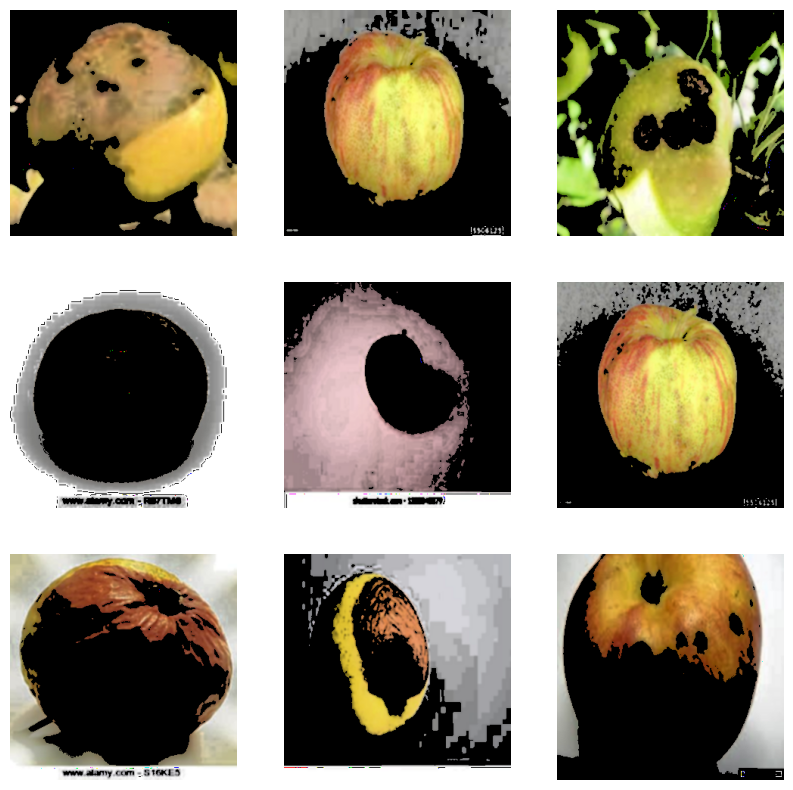

In [13]:
# Define the color range threshold for the apples in HSV format
lower_threshold = np.array([0, 0, 0])
upper_threshold = np.array([179, 255, 123])

remove_bg_train = np.array([remove_background(img, lower_threshold, upper_threshold) for img in preprocessed_train])

show_images(remove_bg_train)

## Data augmentation

In [14]:
# Load your dataset
X = np.array(remove_bg_train)  # Replace this with your actual dataset
y = np.array(labels_train)  # Replace this with your actual labels

# Create an ImageDataGenerator object with the desired augmentations
data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Set the batch size for the data generator
batch_size = 32

# Create an iterator for the dataset
data_iterator = data_generator.flow(X, y, batch_size=batch_size)

In [24]:
num_classes = 4  # Replace this with the number of disease classes in your dataset
img_height = 300
img_width = 300

# Load the pre-trained ResNet50 model without the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Fine-tune the ResNet50 model by adding a global average pooling layer followed by a dense classification layer
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Set the base_model layers as non-trainable, so we only fine-tune the newly added layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
model.fit(
    data_iterator, 
    steps_per_epoch=len(X_train) // batch_size, 
    validation_data=validation_data_iterator,
    validation_steps=len(X_val) // batch_size,
    epochs=50
)

NameError: name 'X_train' is not defined